# Notebook relacionado con el pronóstico del precio de venta de los productos agricolas.

Teniendo en cuenta que las dos funciones objetivo del proyecto de investigación titulado: **Modelo de optimización multiobjetivo para la programación de la producción agrícola a pequeña escala en Santander, Colombia**,  tienen en consideración el parámetro de precios de venta de cada kilo de producto agrícola recogido durante el horizonte de planeación (e.g. Objetivo 1: Maximizar ingresos por ventas, Objetivo 2: Minimizar riesgo financiero), y que la prueba del modelo se realizará en un contexto local (Departamento de Santander); se propone estimar el precios de venta de los productos a considerar durante el caso aplicado, mediante la formulación de modelos auto regresivo. Los modelos son desarrollados a partir del análisis histórico de los precios de venta por kilogramo de cada producto en la central de abastos de Bucaramanga, en un periodo comprendido entre la primera semana de enero de 2013 hasta la última semana de diciembre de 2017.

El Notebook está estructurado de tal manera que sea posible hacer un seguimiento a la construción de los modelos de pronósticos. Para ello, se divide en las siguientes secciones:

[1. Adquisición de los datos y depuración](#seccion 1)

[2. Verificación de los supuestos de _Estacionariedad_](#seccion 2)

[3. Construcción general del modelo Arima](#seccion 3)

[4. Construcción del modelo Garch](#seccion 4)

[5. Ecuaciones de pronóstico](#seccion 5)

[6. Discusión y observaciones generales](#seccion 6)

# <a id='seccion 1'></a> 1. Adquisición de los datos y depuración

En la primera sección se cargan los paquetes necesarios para trabajar los modelos de pronósticos:

In [1]:
#options(warm=-1) # No mostar mensajes de alerta

In [2]:
library(randtests)#Evaluar pruebas de estacionariedad
library(tseries)  #Evaluar pruebas de estacionariedad
library(urca)     #Evaluar la presencia de raices unitarias
library(Amelia)   #Imputar datos
library(lmtest)   #Generar modelos de regresión lineal
library(mice)     #Imputar datos
library(readr)    #Cargar archivos csv
library(ggplot2)  #Construcción de gráficas
library(forecast) #Modelos de pronóstico
library(reshape2) #Construcción de gráficas
library(VIM)      #Imputación de datos
library(rugarch)  #Generar modelos de pronóstico de volatilidad



Attaching package: 'tseries'

The following object is masked from 'package:randtests':

    runs.test

Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.4.4"## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'readr' was built under R version 3.4.4"Loading required package: colorspace
Loading required package: grid
Loading required package: data.table

Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.

Suggestions

Ahora es cargada la base de datos de precios y se observan los campos que la componen:

In [3]:
DATA <- read.csv(file="DATA_BUCARA.csv", header=TRUE, sep=";") 
# carga desde archivo .csv ubicado en el directorio raiz"
DATA <- as.data.frame(DATA) 
#transformación de los datos a formato Data Frame

## Descripción del Dataset

[1] "Visualización de los 5 primeros datos y 5 variables"


Fecha,Ahuyama,Arverja,Cebolla.Cabezona,Cebolla.junca
04/01/2013,676,2158,933,920
11/01/2013,652,1921,823,665
12/01/2013,614,1761,718,724
19/01/2013,636,1750,700,604
26/01/2013,619,1905,625,646
02/02/2013,620,1892,630,657


[1] "Características de los datos y 5 variables"
'data.frame':	261 obs. of  5 variables:
 $ Ahuyama         : int  676 652 614 636 619 620 632 600 581 600 ...
 $ Arverja         : int  2158 1921 1761 1750 1905 1892 1711 1893 1975 3520 ...
 $ Cebolla.Cabezona: int  933 823 718 700 625 630 633 575 506 575 ...
 $ Cebolla.junca   : int  920 665 724 604 646 657 622 668 623 689 ...
 $ Cilantro        : int  5569 7317 6250 3854 4333 6833 7719 9619 NA NA ...
NULL
[1] "Resumen descriptivo de los datos y 5 variables"


        Fecha        Ahuyama          Arverja     Cebolla.Cabezona
 21/12/2013:  2   Min.   : 422.0   Min.   :1163   Min.   : 386    
 01/02/2014:  1   1st Qu.: 568.0   1st Qu.:2160   1st Qu.: 808    
 01/03/2014:  1   Median : 660.0   Median :2660   Median :1225    
 01/04/2017:  1   Mean   : 700.4   Mean   :2933   Mean   :1301    
 01/05/2015:  1   3rd Qu.: 800.0   3rd Qu.:3350   3rd Qu.:1657    
 01/07/2017:  1   Max.   :1354.0   Max.   :8033   Max.   :3350    
 (Other)   :254                    NA's   :1                      
 Cebolla.junca 
 Min.   : 418  
 1st Qu.: 810  
 Median :1019  
 Mean   :1113  
 3rd Qu.:1245  
 Max.   :3239  
               

[1] "Visualización de los datos perdidos"


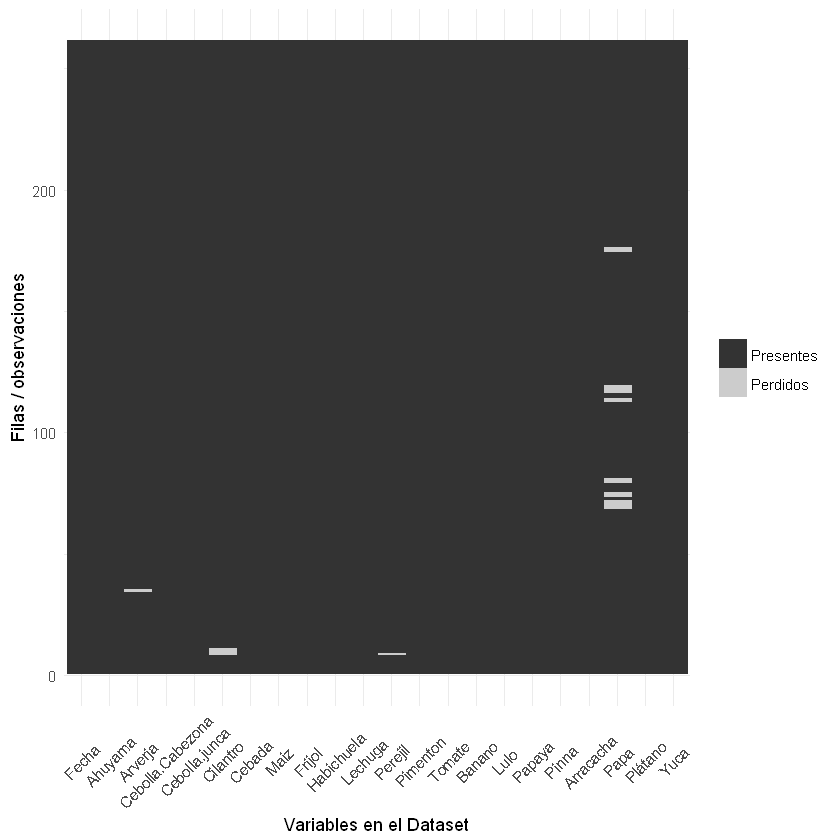

In [4]:
#A continuación se expone el código para describir el dataset.
print("Visualización de los 5 primeros datos y 5 variables")
head(DATA[,1:5])
print("Características de los datos y 5 variables")
#Para mejorar la visualización, no se muestra la variable Fecha
print(str(DATA[,2:6]))
print("Resumen descriptivo de los datos y 5 variables")
summary(DATA[,1:5])
print("Visualización de los datos perdidos")
#Con el propósito de identificar si existen datos perdidos 
#(una aproximación visual), se adapta una función creada por
#Nicholas Tierney 
#https://njtierney.github.io/

#Inicio de la función
ggplot_missing <- function(x){
  
x %>% 
is.na %>%
melt %>%
ggplot(data = .,
aes(x = Var2,
y = Var1)) +
geom_raster(aes(fill = value)) +
scale_fill_grey(name = "",
labels = c("Presentes","Perdidos")) +
theme_minimal() + 
theme(axis.text.x  = element_text(angle=45, vjust=0.5)) + 
labs(x = "Variables en el Dataset",
y = "Filas / observaciones")
}
#Fin de la Función
ggplot_missing(DATA)

## Imputación del Dataset

Teniendo en cuenta que no están presentes todos los datos en el Dataset de precios, se procede a realizar la imputación del mismo. Para la imputación se realiza un cálculo previo de la cantidad de datos perdidos, con dicho valor y teniendo en cuenta la dispersión de los datos observadas en la Figura **Visualización de datos perdidos**, se selecciona la imputación de promedio de k vecinos, con 5 vecinos ya que  es un método de clasificación supervisada (Aprendizaje, estimación basada en un conjunto de entrenamiento y prototipos) que sirve para estimar la función de densidad ${F(x/Cj)}$ de las predictoras ${x}$ por cada clase ${C_{j}}$ (Fix,1989)

In [5]:
#Primero se hace un cálculo de datos perdidos
print("La cantidad de datos perdido por variable antes de imputar es")
colSums(is.na (DATA))
#Se realiza la imputación mediante k vecinos
#Se aplica la función kNN (K Nearest Neighbour Imputation) 
#y se guarda como una nueva variable
DATA_IMP<-kNN(DATA, variable = colnames(DATA), metric = NULL, k = 5,
dist_var = colnames(DATA), weights = NULL, numFun = median,
catFun = maxCat, makeNA = NULL, NAcond = NULL, impNA = TRUE,
donorcond = NULL, mixed = vector(), mixed.constant = NULL,
trace = FALSE, imp_var = TRUE, imp_suffix = "imp", addRandom = FALSE,
useImputedDist = TRUE, weightDist = FALSE)
#Los datos son actualizados en el Dataframe
DATA<-as.data.frame(DATA_IMP[,1:length(DATA)])


[1] "La cantidad de datos perdido por variable antes de imputar es"


Fecha          Ahuyama          Arverja Cebolla.Cabezona 
               0                0                1                0 
   Cebolla.junca         Cilantro           Cebada             Maiz 
               0                3                0                0 
          Frijol       Habichuela          Lechuga          Perejil 
               0                0                0                1 
        Pimenton           Tomate           Banano             Lulo 
               0                0                0                0 
          Papaya            Pinna        Arracacha             Papa 
               0                0                0               15 
         Plátano             Yuca 
               0                0

Finalmente, las series históricas se presentan visualmente a continuación:

Warning message:
"Removed 155 rows containing missing values (geom_path)."

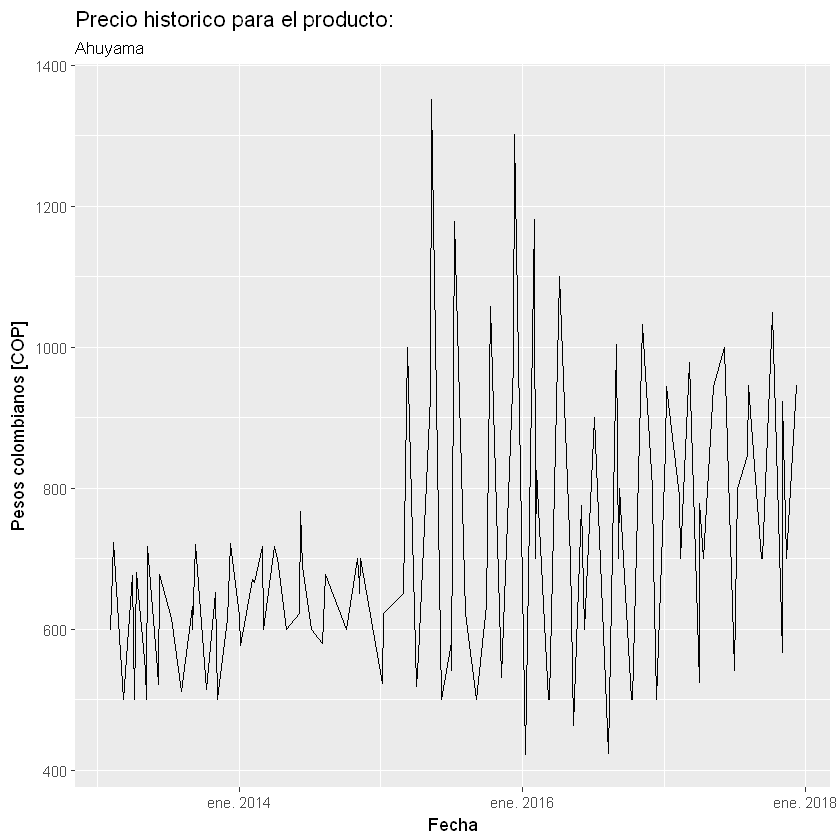

In [8]:
#Primero se construye una función para graficar todas las 
#series de manera independiente utilziando un bucle

#Creación de la función
GRAFICAR <- function(x, na.rm = TRUE, ...)
{
nm <- names(x)
for (i in seq_along(nm[2:length(x[1,])])) 
{
plots <-ggplot(x,aes(as.Date.character(x[,1],"%m/%d/%Y"),+
x[,(i+1)])) + geom_line()
plots<-plots+labs(x = "Fecha")+labs(y = "Pesos colombianos [COP]")+
labs(title = "Precio historico para el producto:", subtitle = nm[i+1])+
scale_x_date(date_labels = "%b %Y")
print(plots)
#Opcional si desean guardar la imagen
#ggplot(x,aes(x[,1], x[,(i)])) + geom_line()
#ggsave(plots,filename=paste("00 ",nm[i],".png",sep=""))
}
}
#Fin de la función

#Se ejecuta la función, y se meustra el ejemplo de la primera
#gráfica
GRAFICAR(DATA[1:2])

# <a id='seccion 2'></a> 2. Verificación de los supuestos de Estacionariedad

Una vez construído el Dataset, se aplican diversas pruebas con el propósito de determinan si las series son o no estacionarias, de no presentar esa característica, el siguiente paso es transformar las series a estacionarias para posteriormente generar los modelos.

## 2.1 Descripción de las pruebas

### 2.1.1 Prueba de raiz Unitaria

Las primeras tres pruebas aplicadas durante el presente trabajo pertenecen a la familia de las raíces unitarias, las cuales según citan Nisar y Hanif: (2012, p. 418) “pueden ser usadas para evaluar la eficiencia de los mercados, puesto que dicho comportamiento demanda aleatoriedad (i.e. serie no estacionaria) en los precios (Hassan, Abdullah, & Shah, 2007)”. 

**1. Raíz unitaria con deriva y con tendencia** La primera prueba se enfoca en determinar si el modelo general de regresión se comporta como el descrito a continuación: 
\begin{equation*}
Y_t= β_1  + β_2 t + β_3 Y_(t-1)  + u_t
\end{equation*}
Donde $u_t$ es un término de error de ruido blanco (se distribuye normalmente con media = 0 y varianza = 1), $t$ es el tiempo medido cronológicamente, $Y_t$ la realización de la serie, $β_1$ indica el valor de deriva, $β_2$ la tendencia temporal y $β_3$ la raíz del proceso.

**2. Raíz unitaria con deriva y sin tendencia** Del modelo general de regresión se puede presentar una forma especial en la cual $β_1≠0$, $β_2=0$, $β_3=1$, y se conoce como Caminata Aleatoria con Deriva (CAD), ésta se caracteriza por ser no estacionaria con tendencia determinista:
\begin{equation*}
Y_t= β_1  +  β_3 Y_(t-1)  + u_t
\end{equation*}

**3. Raíz unitaria sin deriva y sin tendencia**  Del modelo general de regresión se puede presentar una forma especial en la cual $β_1=0$, $β_2=0$, $β_3=1$, y es conocido como Caminata Aleatoria Pura (CAP), el cual genera un proceso no estacionario:

\begin{equation*}
Y_t= Y_(t-1)  + u_t
\end{equation*}


### 2.1.2 Prueba de rachas (Prueba de Geary)

El cuarto test aplicado es una prueba no paramétrica que busca determinar si las realizaciones en una serie siguen un comportamiento aleatorio (Geary, 1935; Gujarati & Porter, 2010), para ello se estima un valor crítico Z teniendo en cuenta la siguiente ecuación:
\begin{equation*}
Z= R-X⁄σ^2 
\end{equation*}
Donde $Z$ es una variable que se distribuye de manera Normal, $R$ es el número total de rachas, $X=  ((2*n^1*n^2 ))⁄((n)+1)$ (Media de la serie), $n^1$  representa el número total de rachas positivas, $n^2$ el número total de rachas negativas, $n= (n^1+n^2 )$, $ σ^2= ((2*n^1*n^2*(2*n^1*n^2-n)))⁄(((n)^2*(n-1)))$ (Varianza de la serie).

### 2.1.3 Análisis de Auto correlaciones (Prueba d, de Dubrin-Watson)

La quinta prueba es el análisis de auto correlaciones de Durbin-Watson (Savin & White, 1977), ésta se utiliza para detectar la presencia de auto correlación en los residuos (errores de predicción) de un análisis de la regresión. El estadístico es calculado a continuación:

\begin{equation*}
d=\frac{\sum_{t=2}^T (e_t-e_(t-1))^2}{\sum_{t=1}^T(e_t)^2}
\end{equation*}

Donde $d≈(2- β_3)$, i8ndicando que $β_3$ representa el grado de correlación de la muestra de los residuos. Un valor "d = 2 " indica que no hay auto correlación.


### 2.1.4 Estimación del coeficiente de Hurst

La sexta prueba es la estimación del coeficiente de Hurst, éste es una medida que indica el grado de independencia de las series de tiempo. Cuando el valor del coeficiente se encuentre en $H=0.5$, se considera que la serie tiene un comportamiento de ruido blanco. Por otra parte, si $(0.5≤H<1]$ se dice que la serie presenta persistencia o auto correlaciones, de manera análoga, si  $[0≤H≤0.5)$ la serie presenta un comportamiento anti persistente o de correlación negativa. Durante el presente trabajo es aplicada la variante propuesta por Andrew Lo, la cual tiene en cuenta la memoria interna de la serie, donde ${\hat\sigma_x}^2 $ y ${\hat y_j}^2 $ son los estimadores de varianza y covarianza de la serie, $a$ el tamaño de la subserie, $R(N)$ el rango de datos de la subserie:

\begin{equation*}
F'(N)= \frac{R(N)}{({\hat\sigma_x}^2 +2\sum_{j=1}^a(1-\frac{j}{a+1})*\hat{y_j})^2}
\end{equation*}

## 2.2 Resultados de las pruebas

In [12]:
#Con el fin de evitar sobre utilizar bucles, 
#para esta etapa se programará la estimación de 
#las pruebas, y éstas se imprimiran posteriormente

#Se construye una variable donde se almacenarán 
#los resultados
COEF<-as.data.frame(replicate(length(DATA[1,])-1, 0*(1:6)))

#Se programa una función que estime el
#coeficiente de Hurst
#Inicio de la función
hurst <- function(x)
{
  
  N <- length(x)
  s <- x[2:N]
  t <-1:N
  par1<-3
  RS<-0*(1:par1)
  tau<-RS
  for(i in 1:par1){
    m <- floor(N/(i))
    R<-0*(1:i)
    S<-0*(1:i)
    Var<-R
    for(j in 1:i){
      smin<-1+(j-1)*m
      smax<-j*m-1
      r <- s[smin:smax]
      M<-mean(r)
      x2<-r-M
      V <- cumsum(x2)
      R[j]<-max(V)-min(V)
      Var[j]<-var(r)
      wj<-(1-(j/(i+1)))
      x22<-0
      for(z in 1:(length(x2)-1)){
        x22[z]<-x2[z]*x2[z+1]
      }
      cova<-sum(x22)
      S[j] <- (Var[j] +  2*wj*cova/m)^(0.5)
    }
    tau[i]<-m
    RS[i]<-mean(R/S) 
  }
  XX<- data.frame(log10(tau),log10(RS))
  x <- XX$log10.tau.
  y <- XX$log10.RS.
  n <- nrow(XX)
  xy <- x*y
  m2 <- (n*sum(xy)-sum(x)*sum(y)) / (n*sum(x^2)-sum(x)^2)
  m2
  
  return(m2)
}
#Fin de la función
DATA_BUCKUP<-DATA
#Se inicia un bucle que recorra el listado de productos
for(i in 1:(length(DATA[1,])-1))
{
#Prueba de raíz unitaria
# Si el p-valor es menor que 0.05 no podemos rechazar 
#la hipótesis nula (para cada caso):
#se transforman los datos
DATA[,i+1]<-as.data.frame.vector(DATA[,i+1])

#Se aplican todas las pruebas, bajo el supuesto de 
#la existencia de una tendencia, para evaluar 
#las 3 hipótesis
#los datos son almacenados en la variable COEF
#para las tres primeras filas

df<-ur.df(DATA[,i+1],type="trend",lags=0, selectlags = "AIC")
#tendencia, 
COEF[1,i]<-summary(df)@testreg$coefficients[10] 
#Hipótesis nula, Hay raiz unitaria
COEF[2,i]<-summary(df)@testreg$coefficients[11] 
#Hipótesis nula, Hay raiz unitaria sin tendencia
COEF[3,i]<-summary(df)@testreg$coefficients[12] 
#Hipótesis nula, Hay raiz unitaria sin tendencia y sin deriva
      
#Prueba de rachas
#si p-valor es menor a 0.05, no se rechaza 
#la hipótesis nula de aleatoriedad.
xr<-DATA[2:length(DATA[,i+1]),i+1]/DATA[1:(length(DATA[,i+1])-1),i+1]
a<- randtests::runs.test(xr)
    
COEF[4,i]<-a$p.value
#Autocorrelaciones
#si el pvalor es menor a 0.05, no se rechaza la hipótesis nula
#(existe Autocorrelación)
x1<-1:length(DATA[,1])
aut<-dwtest(DATA[,i+1] ~ x1) 
COEF[5,i]<-aut$p.value
  

#Coeficiente de Hurst
    
#Se transforman los datos para determinar su rendimiento
xr<-DATA[2:length(DATA[,i+1]),i+1]/DATA[1:(length(DATA[,i+1])-1),i+1]
#Se aplica la función para estimar el coeficiente de Hurst 
#y se almacena en la sexta posición
COEF[6,i]<-hurst(xr)
  
  
}
#Se cambia el formato de los valores
COEF<-format(COEF, scientific=FALSE)
#Se guardan los valores d emanera local
write.csv(COEF, file="COEFICIENTES_FINAL.csv")  

#Se transforma el formato de los valores para poder hacer cálculos
COEF<-data.matrix(COEF, rownames.force = NA)
#Para mejorar la visualziación, se truncan los valores
COEF<-round(COEF,3)

#Con el fin de presentar cada prueba por separado, se transforma
#y transpone la matriz de coeficientes
n<-colnames(DATA[,-1])

DATA2 <- as.data.frame(t(COEF[,]))
names(DATA2)[1]<-paste("Raiz \n Unitaria (R.U.)")
names(DATA2)[2]<-paste("R.U. \n sin tendencia")
names(DATA2)[3]<-paste("R.U.\n sin tendencia \ny sin deriva")
names(DATA2)[4]<-paste("Prueba \n de rachas")
names(DATA2)[5]<-paste("Auto \n correlaciones")
names(DATA2)[6]<-paste("Coeficiente \n de Hurst")
DATA2$NOMBRE<-n
row.names(DATA2) <- n
DATA2
DATA<-DATA_BUCKUP

,Raiz Unitaria (R.U.),R.U. sin tendencia,R.U. sin tendencia y sin deriva,Prueba de rachas,Auto correlaciones,Coeficiente de Hurst,NOMBRE
Ahuyama,0.010,0.003,0.420,0.083,0,0.323,Ahuyama
Arverja,0.016,0.001,0.224,0.384,0,0.275,Arverja
Cebolla.Cabezona,0.054,0.003,0.283,0.013,0,0.297,Cebolla.Cabezona
Cebolla.junca,0.013,0.000,0.015,0.000,0,0.279,Cebolla.junca
Cilantro,0.000,0.000,0.170,0.618,0,0.275,Cilantro
Cebada,0.000,0.000,0.000,0.000,0,0.378,Cebada
Maiz,0.000,0.000,0.000,0.000,0,0.083,Maiz
Frijol,0.000,0.000,0.299,0.709,0,0.333,Frijol
Habichuela,0.000,0.000,0.480,0.709,0,0.155,Habichuela
Lechuga,0.000,0.000,0.477,0.080,0,0.296,Lechuga


### 2.2.1 Prueba de raíz unitaria

In [13]:
#Ahora se imprimen los resultados para cada prueba
print('Estos son los productos que presentan un 
comportamiento de raiz unitaria')
print(c("Total de productos:",
        length(DATA2[which(DATA2[,1]<=0.05),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,1]<=0.05),7]
print("Estos son los productos que presentan un 
comportamiento de raiz unitaria sin tendencia")
print(c("Total de productos:",length(DATA2[which(DATA2[,2]<=0.05),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,2]<=0.05),7]
print("Estos son los productos que presentan un 
comportamiento de raiz unitaria sin tendencia
y sin deriva")
print(c("Total de productos:",length(DATA2[which(DATA2[,3]<=0.05),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,3]<=0.05),7]

[1] "Estos son los productos que presentan un \ncomportamiento de raiz unitaria"
[1] "Total de productos:" "19"                 
[1] "Nombre de los productos:"


[1] "Ahuyama"       "Arverja"       "Cebolla.junca" "Cilantro"     
 [5] "Cebada"        "Maiz"          "Frijol"        "Habichuela"   
 [9] "Lechuga"       "Perejil"       "Pimenton"      "Tomate"       
[13] "Banano"        "Lulo"          "Papaya"        "Pinna"        
[17] "Papa"          "Plátano"       "Yuca"

[1] "Estos son los productos que presentan un \ncomportamiento de raiz unitaria sin tendencia"
[1] "Total de productos:" "21"                 
[1] "Nombre de los productos:"


[1] "Ahuyama"          "Arverja"          "Cebolla.Cabezona" "Cebolla.junca"   
 [5] "Cilantro"         "Cebada"           "Maiz"             "Frijol"          
 [9] "Habichuela"       "Lechuga"          "Perejil"          "Pimenton"        
[13] "Tomate"           "Banano"           "Lulo"             "Papaya"          
[17] "Pinna"            "Arracacha"        "Papa"             "Plátano"         
[21] "Yuca"

[1] "Estos son los productos que presentan un \ncomportamiento de raiz unitaria sin tendencia\ny sin deriva"
[1] "Total de productos:" "4"                  
[1] "Nombre de los productos:"


[1] "Cebolla.junca" "Cebada"        "Maiz"          "Banano"

### 2.2.2 Prueba de rachas

In [14]:
print("Estos son los productos que presentan
un comportamiento aleatorio")
print(c("Total de productos:",
length(DATA2[which(DATA2[,4]<=0.05),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,4]<=0.05),7]

[1] "Estos son los productos que presentan\nun comportamiento aleatorio"
[1] "Total de productos:" "8"                  
[1] "Nombre de los productos:"


[1] "Cebolla.Cabezona" "Cebolla.junca"    "Cebada"           "Maiz"            
[5] "Papaya"           "Arracacha"        "Plátano"          "Yuca"

### 2.2.3 Análisis de autocorrelaciones

In [15]:
print("Estos son los productos que 
presentan una autocorrelación")
print(c("Total de productos:",
length(DATA2[which(DATA2[,5]<=0.05),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,5]<=0.05),7]

[1] "Estos son los productos que \npresentan una autocorrelación"
[1] "Total de productos:" "21"                 
[1] "Nombre de los productos:"


[1] "Ahuyama"          "Arverja"          "Cebolla.Cabezona" "Cebolla.junca"   
 [5] "Cilantro"         "Cebada"           "Maiz"             "Frijol"          
 [9] "Habichuela"       "Lechuga"          "Perejil"          "Pimenton"        
[13] "Tomate"           "Banano"           "Lulo"             "Papaya"          
[17] "Pinna"            "Arracacha"        "Papa"             "Plátano"         
[21] "Yuca"

### 2.2.4 Estimación del coeficiente de Hurst

In [16]:
print("Estos son los productos que presentan
un comportamiento de ruido blanco
(H aproximadamente 0.5)")
print(c("Total de productos:",
        length(DATA2[which(DATA2[,6]>=0.4804 | DATA2[,6]>=0.5245),7])))
print("Nombre de los productos:")
DATA2[which(DATA2[,6]>=0.4804 | DATA2[,6]>=0.5245),7]

[1] "Estos son los productos que presentan\nun comportamiento de ruido blanco\n(H aproximadamente 0.5)"
[1] "Total de productos:" "2"                  
[1] "Nombre de los productos:"


[1] "Arracacha" "Yuca"

# <a id='seccion 3'></a> 3. Construcción general del modelo Arima

El *Modelo ARIMA*  es una combinación de de diversos modelos, entre los que se encuentra el *Modelo AR* (modelo Auto Regresivo), el cual  explica que el valor de una variable en el instante $t$, está en función de los valores históricos; el *Modelo I* (integrado) indica el numero de diferencias ($d$) o integraciones que debe poseer la serie para ser estacionaria; y el *Modelo MA* (Modelos de Media Móvil) indica que el valor de la dicha variable está en función de los errores de períodos anteriores respecto a un valor esperado. Como el ARIMA conjuga los tres modelos, es necesario indicar en  orden el tipo de modelo que presenta, donde los valores $p$ indica el número de rezagos de la variable $Y_t$ hasta $Y_p$ (donde $p<t$ ) y una cantidad $q$ de rezagos entre el error de la variable en $Y_t$ y su respectivo error en el instante $t-q$. De esa manera se representa un ARIMA de orden $p$, $d$, $q$ o $ARIMA(p, d, q)$. De manera general, es posible expresar el modelo ARIMA mediante la siguiente ecuación:

\begin{equation*}
∆^d y_t= μ+ φ_1 ∆^d y_{(t-1)} +…+ φ_p ∆^d y_{(t-p)}+θ_1u_{(t-1)}+…+ θ_q u_{(t-q)}+u_t
\end{equation*}

Donde $μ$ es el intercepto,  $φ_1 ∆^d y_{(t-1)} +…+ φ_p ∆^d y_{(t-p)}$ es el componente autoregresivo del modelo y $θ_1u_{(t-1)}+…+ θ_q u_{(t-q)}+u_t$ indica la media movil. Ahora bien, teniendo en cuenta los resultados obtenidos en la sección de validación de supuestos ([2. Verificación de los supuestos de _Estacionariedad_](#seccion 2)), es necesario integrar las diferentes series con el fin de que éstas presenten un comportamiento de estacionariedad. Para ello los datos son transformados mediante una suavización logarítmica, buscando así evitar distorción derivada de la escala de los precios, posterior a ello, aplicadas funciones de *R* para escoger el mejor modelo ARIMA que se ajuste a cada dato. Los resultados se presentan a continuación.

[1] 1
$mean
Time Series:
Start = 262 
End = 357 
Frequency = 1 
 [1] 590.9346 587.3371 588.2037 587.9950 588.0452 588.0331 588.0361 588.0354
 [9] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[17] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[25] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[33] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[41] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[49] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[57] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[65] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[73] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[81] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355
[89] 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355 588.0355

$lower
Time

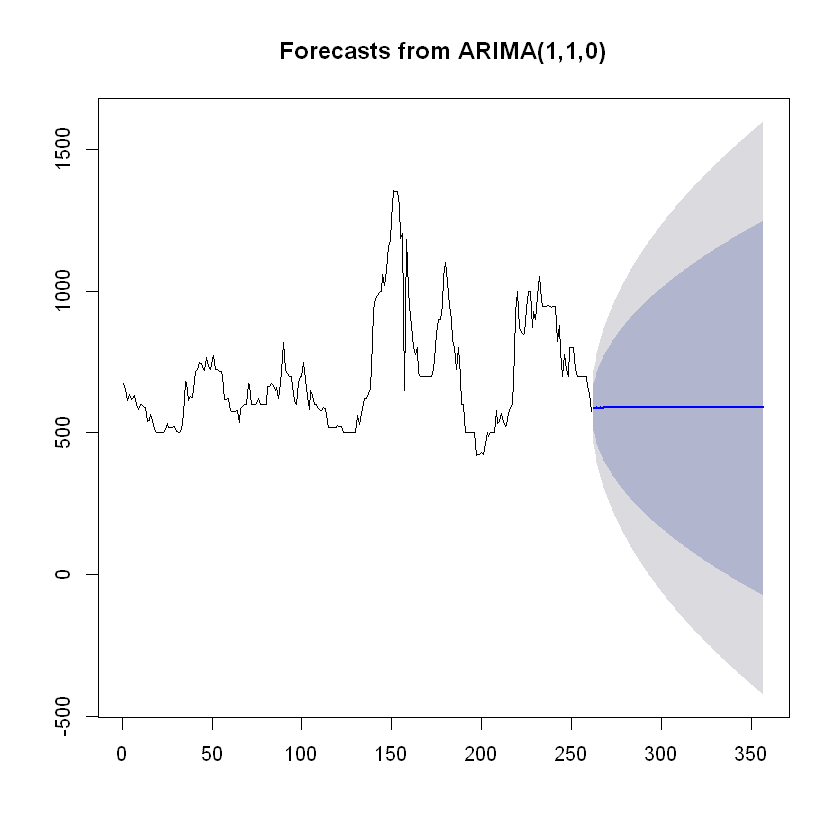

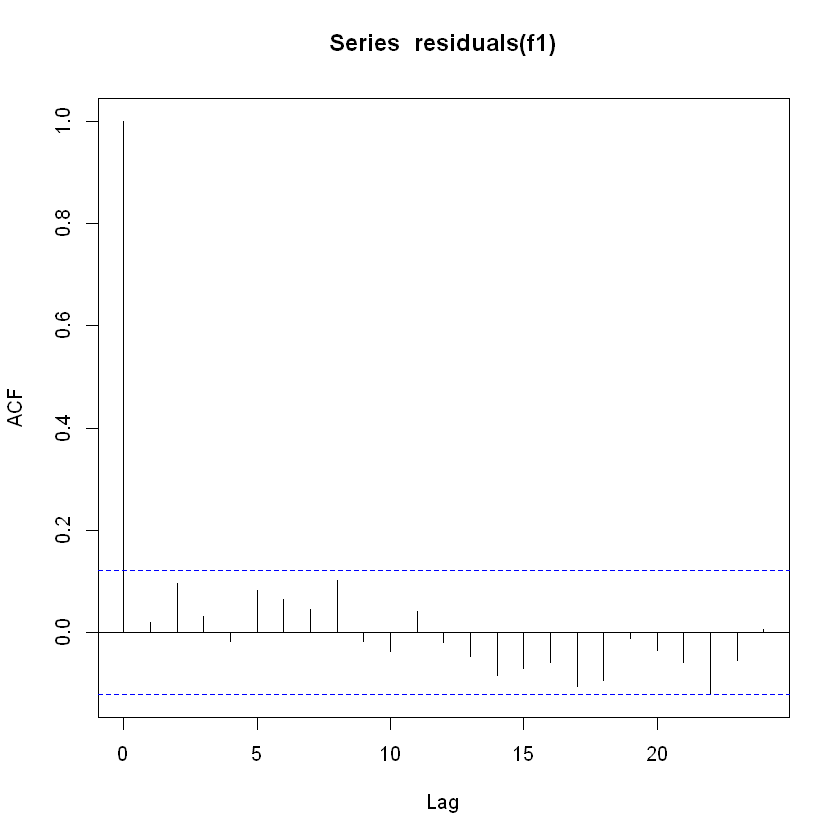

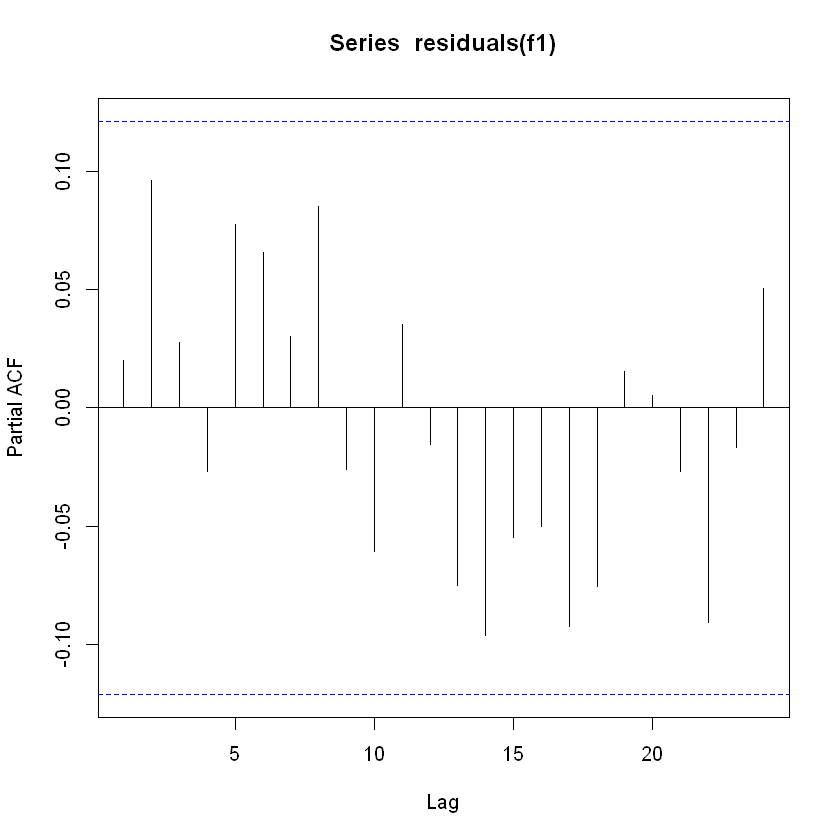

In [19]:
#Se suavizan logaritmicamente los datos
DATA_LOG<-DATA
DATA_LOG[,2:length(DATA)]<-log(DATA[,2:length(DATA)])

#Se crea una función que calcule el mejor modelo ARIMA 
#para cada serie histórica

#Inicio de la función
ESTIMAR_ARIMA <- function(x, y, t, na.rm = TRUE, ...)
{
    #el parámetro x, es la función suavizada logarítmicamente
    x<-as.data.frame(x)
    y<-as.data.frame(y)

    #el parámetro y es la función original
    #el parámetro t, es la cantidad de periodos a pronosticar
    
    nm <- names(x)
      for (i in seq_along(nm[2:length(x[1,])])) 
        {
          print(i)
          #se calcula el mejor modelo que se ajuste a los datos, 
          #los valores p,d,q se almacenan en una variable 
          orden<-arimaorder(auto.arima(x[,i+1]))
          
          #Se construye el modelo ARIMA, teniendo en cuenta el
          #orden de los valores p,d,q
          Ar<-arima(y[,i+1], order = orden, include.mean = TRUE)
          #se genera el pronóstico de los datos
          f1<- forecast(Ar, t)
          
          #se grafican los resultados
          print(plot(f1))
          # con las graficas de ACF y PACF se puede inducir que no 
          #se requiere ningun otro modelo para el pronostico
          acf(residuals(f1))
          pacf(residuals(f1))          
        }
    
}
#Fin de la función

#Se determina el mejor modelo ARIMA, para ello se ejecuta la
#función y se pronostican 96 datos (Horizonte de planeación)
ESTIMAR_ARIMA(DATA_LOG[1:2],DATA[1:2],96)

Teniendo en cuenta los resultados del modelo ARIMA, es posible corroborar mediante los gráficos de autocorrelaciones, que el modelo propuesto presenta un ajuste adecuado, además, para varios productos se encuentran cambios bruscos en los valores históricos, lo cual se alinea con la acumulación de volatilidad, por tanto, se propone el desarrollo de modelos tipo GARCH.

# <a id='seccion 4'></a> 4. Construcción del modelo Garch

Una vez verificado mediante las gráficas de autocorrelación que el modelo obtenido mediante la aplicación del _ARIMA_ es el mejor ajustado y, teniendo en cuenta que a medida que avanza el pronóstico existe una tendencia a aumentar la variabilidad de la series pronósticada, en añadidura a que en algunas series existen lapsos en los que sus precios muestran amplias
variaciones durante prolongados periodos y luego se dan intervalos de una calma relativa tranquilidad. Es posible teorizar que puede existir acumulación de valatilidad y, por tanto, que la variabilidad de la serie en algún rezago pueda incidir sobre la el valor en un instante $t$.

Teniendo en cuenta las características anteriormente descritas, es posible que la variabilidad de los datos en un instante $t$ esté autocorrelacionada con la volatilidad en un instante anterior. Una manera de estimar la volatilidad, es teniendo en cuenta el cambio relativo que ha tenido cada serie. En el presente ejercicio, como los datos de los precios han sido suavizados logaritmicamente, al integrar (diferenciar) la serie, se obtiene una serie de cambios o perturbaciones denominada $X_t$, la cual presenta valores tanto positivos como negativos. Ahora bien, con el propósito de considerar la variabilidad sin importar el signo, es posible expresar la acumulación de volatilidad como:

\begin{equation*}
{X_t}^2 =  β_0 + β_1{X_{t-1}}^2+β_2{X_{t-2}}^2+...+β_p{X_{t-p}}^2+u_t
\end{equation*}

Lo cual indica que la volatilidad en cualquier instante $t$, es una combinación lineal de la volatilidad en instantes anteriores y se conoce como modelo _ARCH_ (Modelo condicional autorregresivo con heteroscedasticidad). Por otra parte, existe una variante denominada Modelo _GARCH_ o Modelo condicional autorregresivo generalizado con heteroscedasticidad; esta variante indica que es posible que la la varianza condicional de $u$ en el tiempo $t$ depende no sólo del término de error al cuadrado del periodo anterior (como sucede en ARCH(1)), sino también de su varianza condicional en el periodo anterior, como indica la siguiente función:

\begin{equation*}
{α_t}^2 =  α_0 + α_1{u_{t-1}}^2+α_2{u_{t-2}}^2+...+α_q{u_{t-q}}^2
\end{equation*}

Una relación interesante entre los modelos _ARCH_ y _GARCH_, es que el modelo puede generalizarse al modelo $GARCH(p,q)$ en
el que existen $p$ términos rezagados del término de error al cuadrado y $q$ términos de las varianzas condicionales rezagadas, además, un modelo $GARCH(p,q)$ equivale a un modelo $ARCH(p + q)$.

Teniendo en cuenta lo anterior, es posible formular un modelo de pronóstico que integre los modelos de predicción de la media (ya sean estos *AR*, *MA*, _ARMA_ O _ARIMA_) con un modelo de pronóstico de volatilidad. Para el modelo de pronóstico de la media, en la sección anterior ([3. Construcción general del modelo Arima](#seccion 3)) se encuentra que  que las series _ARIMA_ presentan un grado de integración $d=1$, por tanto, a partir de la función _auto.arima_ es posible obtener los parámetros de un modelo _ARMA_ para la serie de rentabilidades (o de precios con integración $I=1)$). Con el propósito de simplificar esta sección, se trabajará con la función *ugarchfit* para ajustar el mejor modelo $GARCH(1,1)$ (modelo _GARCH_ básico) que se ajuste al modelo $ARMA(p,q)$.  

In [20]:
#Se crea la base de datos de rendimientos
RENDIMIENTOS<-DATA_LOG[,2:length(DATA_LOG[1,])]
RENDIMIENTOS<-RENDIMIENTOS[2:length(DATA_LOG[,1]),]-
RENDIMIENTOS[1:length(DATA_LOG[,1])-1,]
RENDIMIENTOS$Fecha<-DATA$Fecha[2:length(DATA_LOG[,1])]
#RENDIMIENTOS

#Función para estimar el mejor modelo ARMA
#Inicio de la función
ESTIMAR_ARMA <- function(x, P, Q, na.rm = TRUE, ...)
#x es el parámetro de la base de datos de rendimientos, 
#en este caso, las fechas están al final
#P es el número de rezagos máximos de p
#Q es el número de rezagos máximos de q
{
P<-P
Q<-Q
x<-as.data.frame(x)
nm <- names(x)
ORDEN<-matrix(c((1:((length(x[1,])-1)*3))*0),nrow=(length(x[1,])-1),ncol=3) 
AIC<-0*(1:(length(x[1,])-1))
for (i in seq_along(nm[1:(length(x[1,])-1)])) 
{
final.aic <- Inf
final.order <- c(0,0,0)
for (p in 0: P) for (q in 0: Q) 
{
if ( p == 0 && q == 0) 
{
next
}
arimaFit = tryCatch( arima(x[,i], order=c(p, 0, q)),
                    error=function( err ) 
                        FALSE,warning=function( err ) FALSE )
if( !is.logical( arimaFit ) ) 
{
current.aic <- AIC(arimaFit)
if (current.aic < final.aic) 
{
final.aic <- current.aic
AIC[i]<-final.aic
final.order <- c(p, 0, q)
ORDEN[i,]<-final.order
final.arima <- arima(x[,i], order=final.order)
}
}
else
{
next
}
}  
print(paste0("El Modelo ARMA par el producto ", 
             names(RENDIMIENTOS[i])," es:"))
print(ORDEN[i,])
}
ORDEN<<-ORDEN
}
#Fin de la función
             
#Se crea una función para estimar el mejor modelo GARCH, 
#a partir de de un modelo GARCH (1,1) y el modelo ARMA 
#encontrado en la función anterior

#Inicio de la función
GARCH_PARAMETROS <- function(y, t, na.rm = TRUE, ...)
{
#x es el parámetro de la base de datos de rendimientos, 
#en este caso, las fechas están al final
#y es la matriz que indica los valores p y q del modelo ARMA
#se transforman los datos en dataframe
x<-as.data.frame(y)
#se asigna la variable de p y q del modelo ARMA a una 
#variable interna    
L<-length(x[,1])
T<-t
#cantidad de datos a pronosticar
windowLength = 104 
#tamaño del vector base
foreLength = length(RENDIMIENTOS[,1])- windowLength
#creación del vector de pronóstico
forecasts <- vector(mode="character", length=foreLength)
nm <- names(x)
ORDEN<-matrix(c((1:((length(x[1,])-1)*3))*0),
              nrow=(length(x[1,])-1),ncol=3) 
AIC<-0*(1:(length(x[1,])-1))
for (i in seq_along(nm[1:(length(x[1,])-1)])) 
{ 
#Se especifica la firma del modelo, comenzando 
#con un GARCH(1,1)
spec = ugarchspec(variance.model=
      list(garchOrder=c(1,1)),mean.model=
      list(armaOrder=c(ORDEN[i,1], ORDEN[i,2]), 
      include.mean=FALSE),distribution.model="norm")
fit = tryCatch(ugarchfit(spec, x[,i], solver = 'hybrid'), 
               error=function(e) e, warning=function(w) w)
print(paste0("El mejor modelo GARCH(1,1) para el producto: ", 
             names(RENDIMIENTOS[i]), " es:"))
print(fit@fit$coef)
#Ahora se determina el error de estimación del
#modelo
#se especifica el modelo               
spec <- getspec(fit)
#se ajustan los coeficientes como lista
setfixed(spec) <- as.list(coef(fit))
#se genera el modelo de predicción
garchforecast1 <- ugarchforecast(spec, n.ahead=T,
     n.roll=(L-1)-T, data = x[,i], out.sample = (L-1))
print('Los estadísticos de error de estimación del modelo son:')
#Se almacenan los estadísticos en una varaible
estadisticos<- fpm(garchforecast1, summary = TRUE)  
print(estadisticos)
#Generación de la gráfica (opcional)
plot(garchforecast1, which = 4)
}  
}
#Fin de la función                
                       
#Ahora se crea una función para estimar los coeficientes 
#del ARIMA integrado, con el orden identificado en la 
#función ESTIMAR_ARMA
#Inicio de la función                       
COEFICIENTES_ARIMA <- function(x,na.rm = TRUE, ...)
#el parámetro x, es la función suavizada logarítmicamente
{
nm <- names(x)
for (i in seq_along(nm[2:length(x[1,])])) 
{
#se calcula el mejor modelo que se ajuste a los datos, 
#los valores p,d,q se almacenan en una variable 
orden<-c(ORDEN[i,])
#Se construye el modelo ARIMA, teniendo en cuenta el 
#orden de los valores p,d,q
Ar<-arima(x[,i+1], order = orden, include.mean = TRUE)
print(paste0("El mejor modelo ARIMA de orden: p=",ORDEN[i,1],
    "d=",ORDEN[i,2]," q=",ORDEN[i,3]," para el producto: ", 
    names(RENDIMIENTOS[i]), " es:"))
print(Ar$coef)          
}
}
#Fin de la función

In [21]:
#Debido a la complejidad computacional, se estima el 
#Modelo con 5 rezagos p y 5 rezagos q
#ESTIMAR_ARMA(RENDIMIENTOS,5,5)

#Como ejemplo, se presentan los coeficientes para el 
#producto 1
ESTIMAR_ARMA(RENDIMIENTOS[1:2],5,5)

[1] "El Modelo ARMA par el producto Ahuyama es:"
[1] 2 0 5


[1] "El mejor modelo GARCH(1,1) para el producto: Ahuyama es:"
     omega     alpha1      beta1 
0.00306547 0.16139703 0.32683106 
[1] "Los estadísticos de error de estimación del modelo son:"
         MSE        MAE       DAC
1 0.00678843 0.04635648 0.1969112


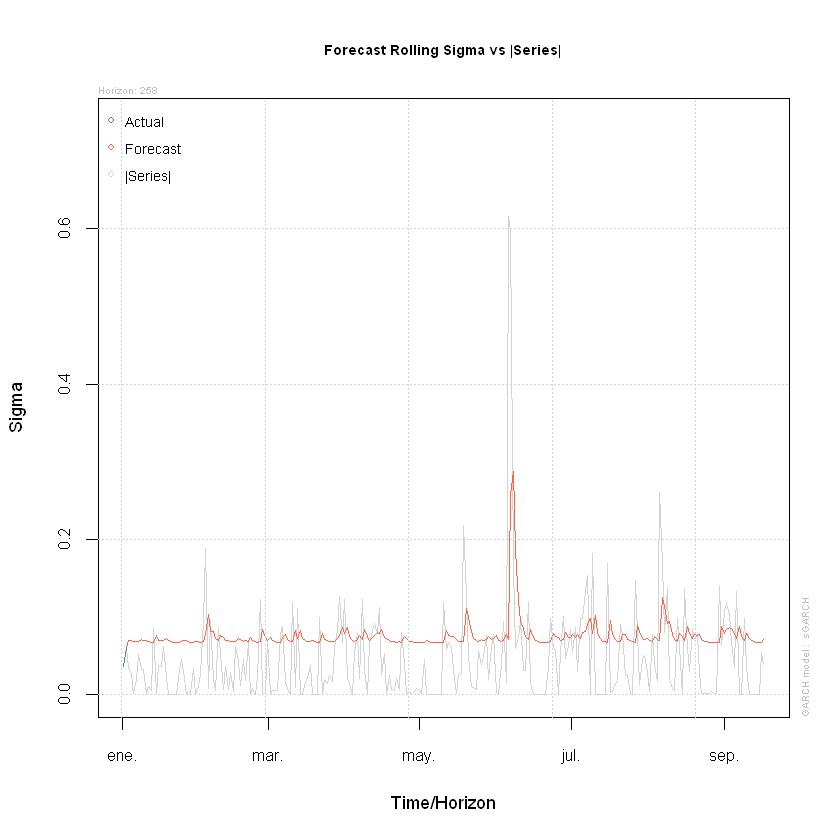

In [22]:
#Teniendo en cuenta los parámetros del modelo ARMA, 
#se busca el mejor modelo GARCH que estima los datos
#históricos
#GARCH_PARAMETROS(RENDIMIENTOS,1)
#Como ejemplo, se presentan los coeficientes para el 
#producto 1
GARCH_PARAMETROS(RENDIMIENTOS[1:2],1)

In [23]:
#para finalizar la construcción del modelo ARIMA-GARCH, 
#se extraen los coeficientes del modelo ARIMA:
#COEFICIENTES_ARIMA(DATA_LOG)
#Como ejemplo, se presentan los coeficientes para el 
#producto 1
COEFICIENTES_ARIMA(DATA_LOG[1:2])

[1] "El mejor modelo ARIMA de orden: p=2d=0 q=5 para el producto: Ahuyama es:"
         ar1          ar2          ma1          ma2          ma3          ma4 
 1.882800148 -0.899184751 -1.129620020  0.265865333 -0.056514935 -0.002679094 
         ma5    intercept 
 0.106337505  6.513721477 


# <a id='seccion 5'></a> 5. Ecuaciones de pronóstico#

Una vez finalizado el modelo de pronóstico de la volatilidad, se integran los dos modelos, con los resultados del capítulo 3 (([Construcción general del modelo Arima](#seccion 3))) se modela el componente lineal de la serie y con los resultados del capítulo 4 ([Construcción del modelo Garch](#seccion 4)) se representa la volatilidad o componente no lineal de cada serie.

A continuación se enlistan los productos bajo estudio y su respectiva ecuación de pronóstico basada en un Modelo _ARIMA-GARCH_.

[5.01 Ahuyama](#seccionP1)

[5.02 Arverja](#seccionP2)

[5.03 Cebolla Cabezona](#seccionP3)

[5.04 Cebolla junca](#seccionP4)

[5.05 Cilantro](#seccionP5)

[5.06 Cebada](#seccionP6)

[5.07 Maiz](#seccionP7)

[5.08 Frijol](#seccionP8)

[5.09 Habichuela](#seccionP9)

[5.10 Lechuga](#seccionP10)

[5.11 Perejil](#seccionP11)

[5.12 Pimenton](#seccionP12)

[5.13 Tomate](#seccionP13)

[5.14 Banano](#seccionP14)

[5.15 Lulo](#seccionP15)

[5.16 Papaya](#seccionP16) 

[5.17 Piña](#seccionP17) 

[5.18 Arracacha](#seccionP18) 

[5.19 Papa](#seccionP19) 

[5.20 Plátano](#seccionP20) 

[5.21 Yuca](#seccionP21) 


### <a id='seccionP1'></a>P1 Ahuyama

\begin{equation*}
(Y_t –Y_{t-1})=6.513721477+1.882800148(Y_{t-1}–Y_{t-2})-0.899184751 (Y_{t-2}–Y_{t-3})-1.129620020u_{t-1}+0.265865333u_{t-2}-0.056514935u_{t-3}-0.002679094u_{t-4}+0.106337505u_{t-5}+ [ 0.00306547+0.32683106{X_{t-1}^2}+0.16139703{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP2'></a>P2 	Arverja

\begin{equation*}
(Y_t –Y_{t-1})=intercepto+ar1(Y_{t-1}–Y_{t-2})+ar2(Y_{t-2}–Y_{t-3})+ar3(Y_{t-3}–Y_{t-4})+ar4(Y_{t-4}–Y_{t-3})+ar5(Y_{t-5}–Y_{t-4})+e1u_{t-1}+e2u_{t-2}+e3u_{t-3}+e4u_{t-4}+e5u_{t-5}+[3.704234e^{-04}+9.816956e^{-01}{X_{t-1}^2} + 6.670345e^{-09}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP3'></a> P3 Cebolla Cabezona

\begin{equation*}
(Y_t –Y_{t-1})=7.05067602+1.03505134(Y_{t-1}–Y_{t-2})+0.73877787(Y_{t-2}–Y_{t-3})-0.78377953(Y_{t-3}–Y_{t-4})-0.01388057(Y_{t-4}–Y_{t-3})-0.31756992u_{t-1}-0.78240257u_{t-2}-0.31067146u_{t-3}+[0.007297969+0.413774395{X_{t-1}^2} +0.43155022{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP4'></a>P4 Cebolla junca

\begin{equation*}
(Y_t –Y_{t-1})=6.9722087+1.5831481(Y_{t-1}–Y_{t-2})-0.4711699(Y_{t-2}–Y_{t-3})-0.1524126(Y_{t-3}–Y_{t-4})-0.8831530u_{t-1}+0.2592950u_{t-2}+[1.577204e^{-04}+9.927226e^{-01}{X_{t-1}^2} +3.305967e^{-08}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP5'></a>P5 	Cilantro

\begin{equation*}
(Y_t –Y_{t-1})=8.69651107+0.01681842(Y_{t-1}–Y_{t-2})+0.55853008(Y_{t-2}–Y_{t-3})-0.37650259(Y_{t-3}–Y_{t-4})+0.89142577 u_{t-1}-0.02637869u_{t-2}+[9.062680e^{-0.4}+9.868391e^{-01}{X_{t-1}^2} + 6.968406e^{-10}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP6'></a>P6	Cebada	

\begin{equation*}
(Y_t –Y_{t-1})=7.49107175 +0.15702902  (Y_{t-1}–Y_{t-2})+0.39231209 (Y_{t-2}–Y_{t-3})-0.04487573 (Y_{t-3}–Y_{t-4})-0.22912665  (Y_{t-4}–Y_{t-3})+0.69000304  (Y_{t-5}–Y_{t-4})+0.39242538 u_{t-1}+0.03609648u_{t-2}+0.23783305u_{t-3}+0.2979619u_{t-4}+0.55438873u_{t-5}+[2.503525e^{-05}+7.160910e^{-01}{X_{t-1}^2} +2.829089e^{-01} {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP7'></a>P7 Maiz	

\begin{equation*}
(Y_t –Y_{t-1})=7.60471985 +0.86253897(Y_{t-1}–Y_{t-2})+0.09128181 (Y_{t-2}–Y_{t-3})-0.21456497  1u_{t-1}+[4.928397e^{-07}+9.989993e^{-01}{X_{t-1}^2} +1.051195e^{-08}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP8'></a>P8 Frijol	

\begin{equation*}
(Y_t –Y_{t-1})=7.61888209+0.05895616 (Y_{t-1}–Y_{t-2})-0.29848931  (Y_{t-2}–Y_{t-3})+0.39168946  (Y_{t-3}–Y_{t-4})+0.51505753  (Y_{t-4}–Y_{t-3})+0.75555751  u_{t-1}+1.13319533 u_{t-2}+0.47534284  u_{t-3}+[2.262364e^{-05}+9.989998e^{-01}{X_{t-1}^2} + 3.710068e^{-10}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP9'></a>P9 Habichuela	

\begin{equation*}
(Y_t –Y_{t-1})=7.2083678 -0.2037103 (Y_{t-1}–Y_{t-2})-0.5413147 (Y_{t-2}–Y_{t-3})-0.1732730(Y_{t-3}–Y_{t-4})+0.3645176  (Y_{t-4}–Y_{t-3})+0.2467020  (Y_{t-5}–Y_{t-4})+1.0413189  u_{t-1}+1.2904921 u_{t-2}+1.1257560u_{t-3}+0.4912510u_{t-4}+
[8.946967e^{-05}+9.989996e^{-01}{X_{t-1}^2} + 5.569119e^{-10}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP10'></a>P10 Lechuga	


\begin{equation*}
(Y_t –Y_{t-1})=6.97860233 +0.82046126  (Y_{t-1}–Y_{t-2})+0.21687765 u_{t-1}-0.09218829  u_{t-2}+0.01110616  u_{t-3}+[0.001941727 +0.501137507 {X_{t-1}^2} +0.332256684{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP11'></a>P11 Perejil	

\begin{equation*}
(Y_t –Y_{t-1})=8.5508773 +0.2388668 (Y_{t-1}–Y_{t-2})+0.5495240(Y_{t-2}–Y_{t-3})+0.4932393 u_{t-1}+[0.01276746 +0.14403695 {X_{t-1}^2} + 0.43945147 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP12'></a>P12 Pimenton	

\begin{equation*}
(Y_t –Y_{t-1})=7.51297313 +0.85104290 (Y_{t-1}–Y_{t-2})+0.04924584u_{t-1}+[0.01238424 +0.22372915 {X_{t-1}^2} + 0.34844438 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP13'></a> P13 Tomate	

\begin{equation*}
(Y_t –Y_{t-1})=7.30435678 -0.97608571  (Y_{t-1}–Y_{t-2})+0.60150857  (Y_{t-2}–Y_{t-3})+0.71965653  (Y_{t-3}–Y_{t-4})+2.01762302  u_{t-1}+1.28694857  u_{t-2}+0.11182957 u_{t-3}+e4u_{t-4}+[4.949029e^{-05 }+9.989998e^{-01 }{X_{t-1}^2} + 2.856260e^{-10 }{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP14'></a>P14 Banano	

\begin{equation*}
(Y_t –Y_{t-1})=7.09454169 +1.08334498 (Y_{t-1}–Y_{t-2})-0.21902430  (Y_{t-2}–Y_{t-3})+0.12771777  (Y_{t-3}–Y_{t-4})0.01801549  u_{t-1}+[0.0003492832 +0.3772963138 {X_{t-1}^2} + 0.3631224741 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))


### <a id='seccionP15'></a>P15 Lulo	

\begin{equation*}
(Y_t –Y_{t-1})=7.8489154 +0.7181886 u_{t-1}+[5.564117e^{-03}+7.114106e^{-09}{X_{t-1}^2} + 1.814536e^{-01}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP16'></a>P16 Papaya	

\begin{equation*}
(Y_t –Y_{t-1})=7.135549764 +1.375959344 (Y_{t-1}–Y_{t-2})-0.475165772 (Y_{t-2}–Y_{t-3})-0.008584973u_{t-1}+[0.0006356732 +0.7774902686 {X_{t-1}^2} + 0.0850591932 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP17'></a>P17 Piña

\begin{equation*}
(Y_t –Y_{t-1})=6.48782335 +0.57030551  (Y_{t-1}–Y_{t-2})+0.68026652 (Y_{t-2}–Y_{t-3})-0.91886326  (Y_{t-3}–Y_{t-4})+0.23840978  (Y_{t-4}–Y_{t-3})+0.26793598 (Y_{t-5}–Y_{t-4})+0.09290026 u_{t-1}-0.30196872  u_{t-2}+0.59725709  u_{t-3}+[8.064475e^{-06}+9.989999e^{-01}{X_{t-1}^2} +3.481836e^{-10}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP18'></a>P18 Arracacha	

\begin{equation*}
(Y_t –Y_{t-1})=7.100025658 +0.009914108  (Y_{t-1}–Y_{t-2})+0.869301929 (Y_{t-2}–Y_{t-3})-0.001711566  (Y_{t-3}–Y_{t-4})+0.089154455  (Y_{t-4}–Y_{t-3})+0.608215019 u_{t-1}-0.374316018 u_{t-2}+[0.009676673 +0.030370318 {X_{t-1}^2} +0.422331542 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP19'></a>P19 Papa

\begin{equation*}
(Y_t –Y_{t-1})=6.9299316 +1.0709694 (Y_{t-1}–Y_{t-2})-0.1092919 (Y_{t-2}–Y_{t-3})[7.830155e^{-06}+9.989999e^{-01}{X_{t-1}^2} +5.719463e^{-10}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP20'></a>P20 Plátano

\begin{equation*}
(Y_t –Y_{t-1})=7.22396619-0.26471887  (Y_{t-1}–Y_{t-2})+0.18933013  (Y_{t-2}–Y_{t-3})+0.86768070  (Y_{t-3}–Y_{t-4})+0.95712236  u_{t-1}+0.68608348 u_{t-2}-0.26705815 u_{t-3}-0.01694113  u_{t-4}+[3.659439e^{-05}+9.963944e^{-01}{X_{t-1}^2} + 2.676367e^{-15}{u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

### <a id='seccionP21'></a>P21 Yuca

\begin{equation*}
(Y_t –Y_{t-1})=6.81904173 -0.73703004  (Y_{t-1}–Y_{t-2})+0.64990752  (Y_{t-2}–Y_{t-3})+0.95037542  (Y_{t-3}–Y_{t-4})+0.08954752  (Y_{t-4}–Y_{t-3})+1.33554235  u_{t-1}+0.33276069 u_{t-2}-0.40335492u_{t-3}-0.07987653u_{t-4}-0.06892027u_{t-5}+[0.001026371 +0.589893082 {X_{t-1}^2} + 0.323391165 {u_{t-1}^2}]
\end{equation*}

([Volver al listado de ecuaciones](#seccion 5))

# <a id='seccion 6'></a> 6. Discusión y observaciones generales

A partir de la aproximación metodológica presentada en este Notebook, es posible construir las diferentes ecuaciones de pronóstico a utilizar para la generación del parámetros _Precio de venta_ que alimenta el modelo de optimización; sin embargo, es necesario resaltar que las ecuaciones desarrolladas son sensibles a modificaciones. Dicha afirmación se deriva de la sensibilidad de que tienen los modelos a los rezagos considerados pues, de 260 datos disponibles, sólo fueron utilizados los 5 rezagos más recientes (tanto para el parámetro $p$, como para el $q$) y, si bien una cantidad mayor de rezagos puede mejorar el pronóstico, por el principio de parsimonia se propende por modelos más sencillos, ya que para este caso, s encontraga una gran carga computacional requerida para estimar los mejores modelos utilziando la función _auto.arima_.

Ahora bien, con el propósito de mejorar los modelos de pronósticos y así aumentar la calidad de los parámetros que alimenten el modelo de optimización, para futuros trabajos se propone la integración de técnicas de aprendizaje mezcladas con modelos autoregresivos.

# Referencias

Fix, E.; Hodges, J.L. (1989). (1951): An Important Contribution to Nonparametric Discriminant Analysis and Density Estimation: Commentary on Fix and Hodges (1951). _International Statistical Review / Revue Internationale de Statistique_ 57 (3): 233-238. doi:10.2307/1403796..

Nisar, S., & Hanif, M. (2012). Testing weak form of efficient market hypothesis: Empirical evidence from South-Asia. _World Applied Sciences Journal_, 17(4), 414–427. https://doi.org/10.3968/5524

Hassan, A., Abdullah, M. S., & Shah, Z. A. (2007). Testing of random walks and market efficiency in an emerging market: An empirical analysis of Karachi Stock Exchange. _The Business Review_, Cambridge, 9(1), 271–280.

In [17]:
write.csv(DATA, file="PRECIOS.csv")  